# Clasificador de datos que permita reconocer la marcha - Hold Out

**Experimiento con multiples clasificadores y seleccionadores/transformadores con Hold Out 16 training y 1 de prueba. Sin usar redes neuronales aún, lo más cercano a eso es MLP, Perceptron, Logistic Regression.**

- Josefa Fernández

## 0. Initial Setup (carga de libreriías)

In [51]:
# Actualizar ciervo
! pip install ciervo --upgrade


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

fatal: destination path 'balu3' already exists and is not an empty directory.


Processing c:\users\josef\onedrive\escritorio\ciervo\experimentos clasificadores\2da semana\con example_marcha_larga\sin redes neuronales\balu3
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=44144 sha256=3dbd8afc02000499dc356a2d614cee1e5a1feac754b4da40c969069946ebbc10
  Stored in directory: C:\Users\josef\AppData\Local\Temp\pip-ephem-wheel-cache-srca9g6d\wheels\41\54\91\86418da23d4486d4610c7d085b1cc0859d6365beec985fc6f6
Successfully built balu3
  Attempting uninstall: balu3
    Found existing installation: balu3 1.0
    Uninstalling balu3-1.0:
      Successfully uninstalled balu3-1.0



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
# ciervo
from ciervo.plots import emg_plot
from ciervo.io import example_marcha_larga

# Manejar señales y otros usos
from scipy import signal
import scipy.signal
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import numpy as np
from scipy.fft import fft

import seaborn as sns
import pandas as pd
import cv2
from scipy.ndimage import binary_fill_holes

#Selection/Transformation
from balu3.fs.sel  import sfs, clean        
from balu3.ft.norm import minmax             
from sklearn.cross_decomposition import PLSRegression
from balu3.ft.trans import pca                                                 
from sklearn.decomposition import FastICA  

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestCentroid                           
from sklearn.naive_bayes import GaussianNB                              
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.tree import DecisionTreeClassifier                         
from sklearn.ensemble import RandomForestClassifier                     
from sklearn.linear_model import LogisticRegression      
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis    
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import Perceptron, SGDClassifier

# Evaluation
from sklearn.metrics   import confusion_matrix, accuracy_score       

## 1. Data Loading

Tomo los archivos de ciervo/tests/data/marcha son 17 archivos

In [54]:
data_files  = example_marcha_larga() # 3 dataframes con data
len(data_files)

3

Ver como se diferencian cada archivo en las señales y datos. Comparo archivo 0 y 1. 

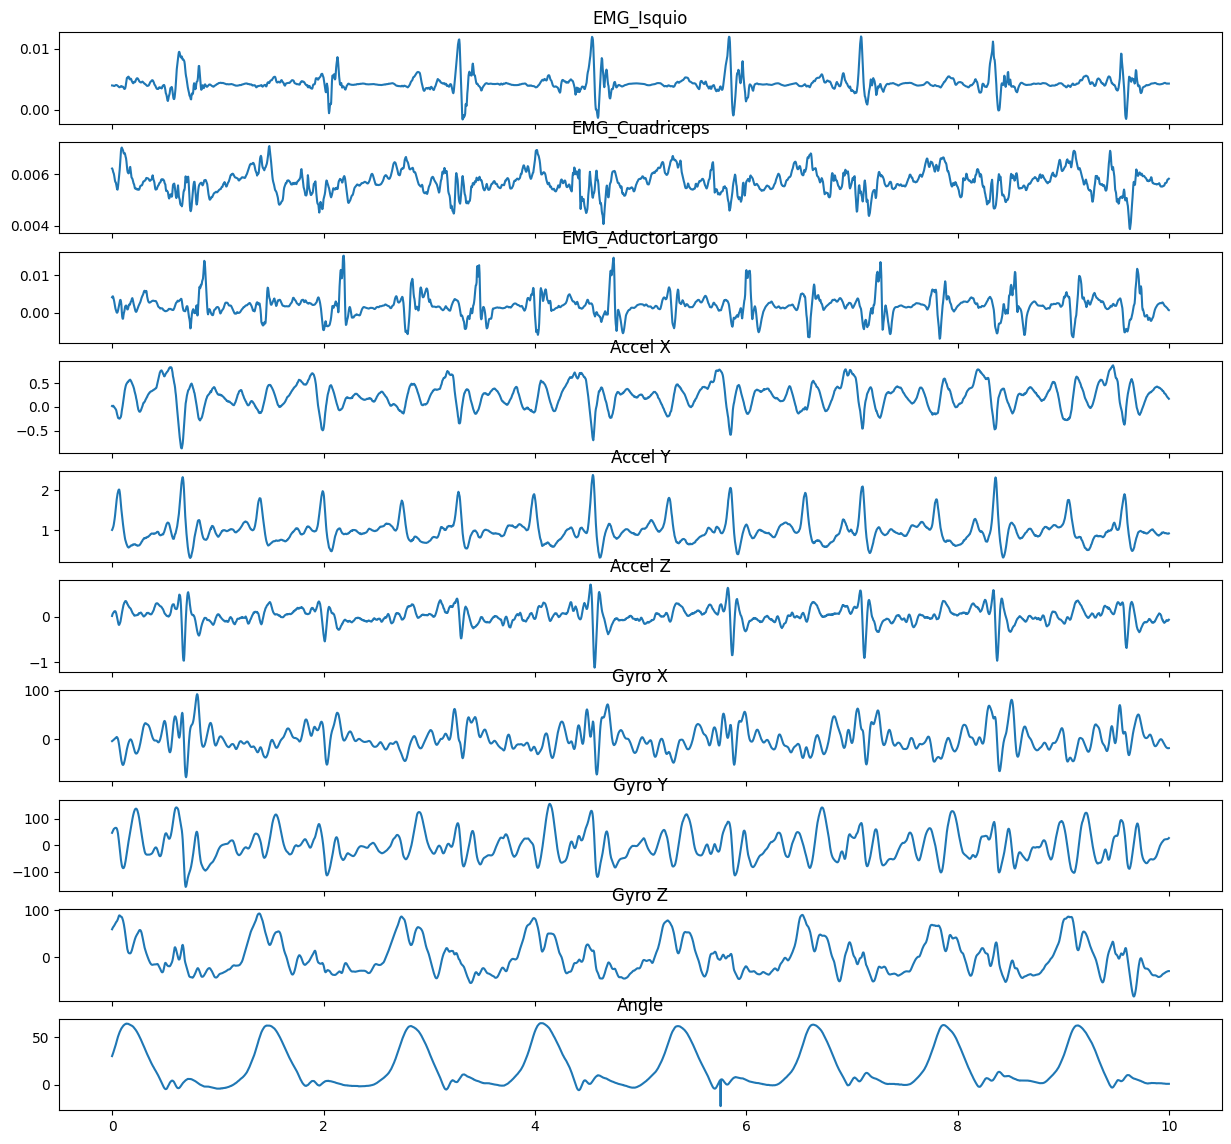

,Elapsed Time,EMG_Isquio,EMG_Cuadriceps,EMG_AductorLargo,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,Angle
0,0.000,0.003977,0.006220,0.004154,0.017334,1.003174,0.011963,-4.028320,46.386719,59.448242,30.014469
1,0.004,0.003971,0.006197,0.004366,0.010742,1.023438,0.047852,-3.356934,50.170898,61.462402,31.217407
2,0.008,0.003960,0.006134,0.004417,0.023193,1.056641,0.067383,-2.563477,54.199219,63.293457,32.529707
3,0.012,0.003948,0.006065,0.004097,0.023438,1.086426,0.080078,-1.892090,57.861328,64.575195,33.842007
4,0.016,0.003902,0.006031,0.003616,0.003418,1.135254,0.093750,-1.037598,60.607910,65.917969,35.263654


In [55]:
emg_plot(data_files[0])
data_files[0].head()

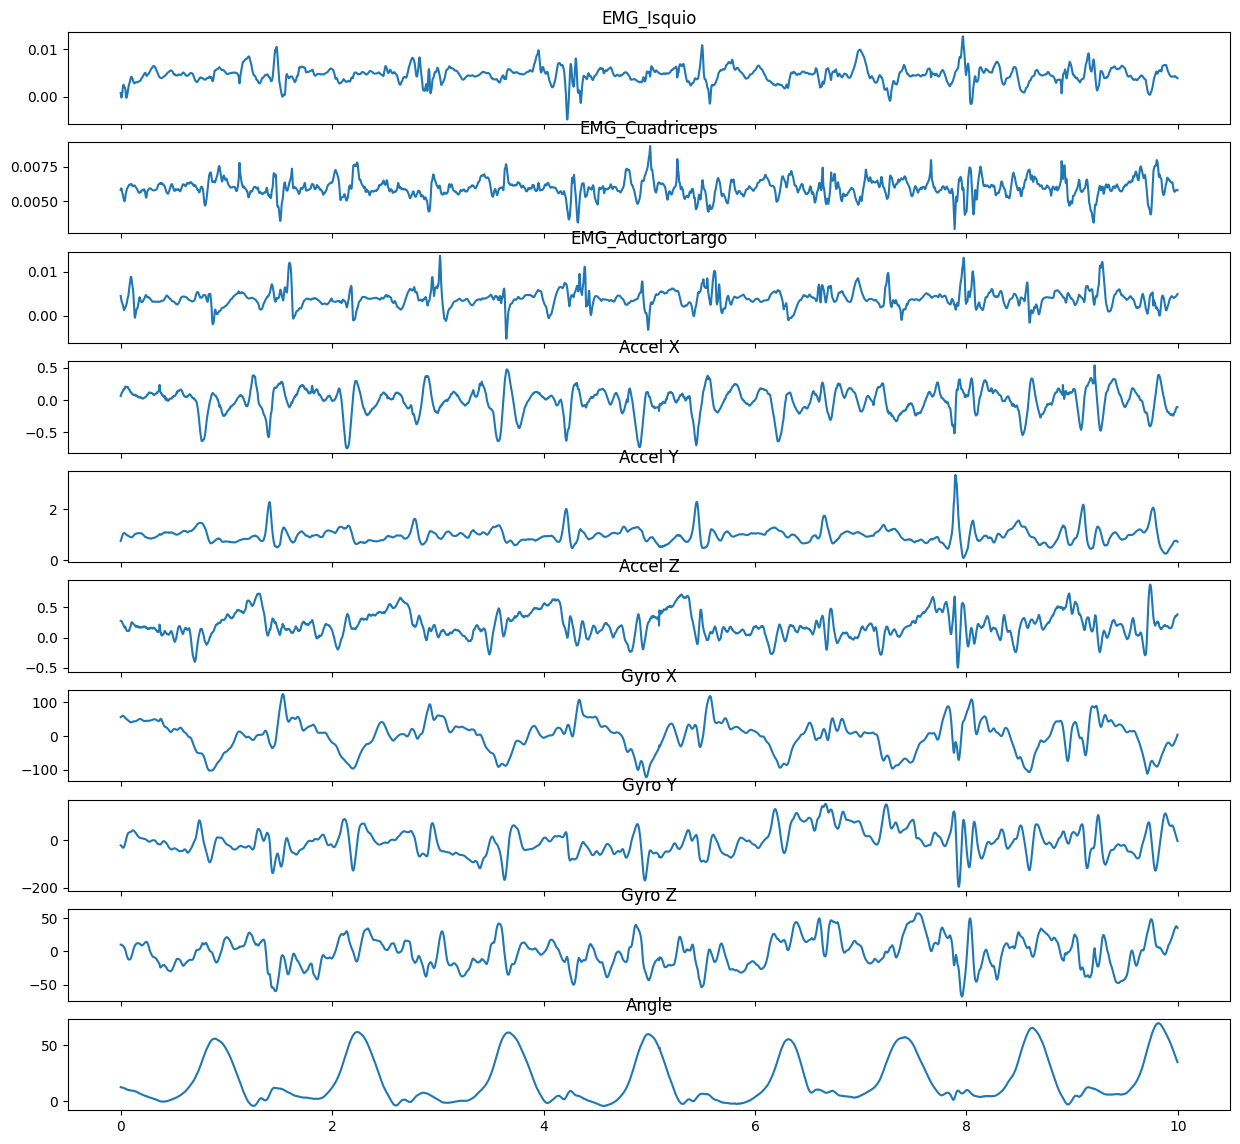

,Elapsed Time,EMG_Isquio,EMG_Cuadriceps,EMG_AductorLargo,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,Angle
0,0.000,0.000750,0.005814,0.004480,0.063965,0.741699,0.276367,55.541992,-20.751953,10.070801,12.407771
1,0.004,-0.000011,0.005939,0.003839,0.088867,0.798096,0.275146,56.640625,-22.216797,10.070801,12.189063
2,0.008,-0.000217,0.005922,0.003382,0.101807,0.864502,0.271729,57.556152,-24.047852,9.765625,12.189063
3,0.012,0.000263,0.005745,0.003021,0.121826,0.925049,0.263428,58.410645,-26.428223,9.155273,12.079700
4,0.016,0.001076,0.005625,0.002758,0.129150,0.974854,0.243652,59.204102,-28.808594,8.789062,12.079700


In [56]:
emg_plot(data_files[1])
data_files[1].head()

Dataframe en pandas
 
Elapsed Time: Tiempo en segundos 

- **Isquio:** Señal EMG del músculo isquiotibial 
- **Cuadriceps:** Señal EMG del músculo cuádriceps 
- **GLMedio:** Señal EMG del músculo glúteo medio 
- **AductorLargo:** Señal EMG del músculo aductor largo 
- **Angle** 

Se puede observar igual diferencias entre los dos archivos que se supone que se esta realizando el mismo movimiento. 

## 2. Feature Extraction (función extracción caracteristicas del 100% de los datos)

### 2.1. Downsampling and feature extraction from EMG signals

#### 2.1.1. Identifica y visualiza cumbres en señal de angulo de la marcha

Se usa find_peaks para identificar cumbres en la señal de angulo de los datos de marcha. 

Retorna peaks[0], con indices de los picos encontrados en la señal de angulo. Como también se realiza una figura para visualizar las cumbres detectadas, representado con un punto rojo.

[    34    370    707   1016   1338   1658   1966   2282   2589   2906
   3212   3520   3819   4137   4469   4794   5191   5525   5898   6215
   6540   6865   7178   7495   7803   8124   8436   8747   9065   9384
   9688   9999  10322  10623  10940  11252  11565  11879  12202  12546
  13346  13660  13954  14254  14555  14858  15162  15463  15770  16066
  16358  16653  16951  17254  17554  17864  18175  18471  18762  19064
  19371  19659  20009  20320  20630  20940  21244  21545  21855  22156
  22464  22774  23072  23386  23685  23989  24301  24603  24904  25202
  25514  25822  26135  26463  26792  27138  27497  27820  28145  28464
  28765  29071  29378  29714  30016  30341  30581  30977  31283  31593
  31883  32186  32487  32791  33095  33404  33702  34004  34322  34610
  34932  35210  35489  35794  36097  36404  36711  37024  37326  37633
  37943  38251  38560  38869  39171  39457  39748  40043  40342  40638
  40940  41241  41554  41865  42180  42502  42841  43161  43471  43779
  4408

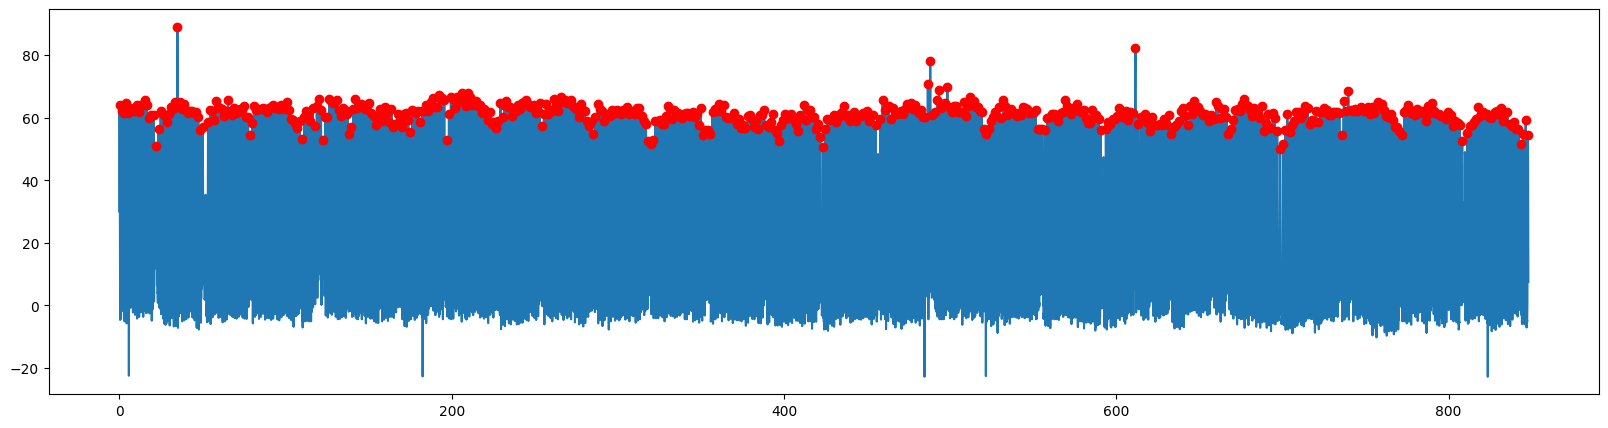

In [57]:
peaks = find_peaks(data_files[0]['Angle'], height=50, distance=125, width=20)
print(peaks[0])
#figura
fig = plt.figure(figsize=(20, 5))
plt.plot(data_files[0]['Elapsed Time'], data_files[0]['Angle'])
plt.plot(peaks[0]/250, data_files[0]['Angle'][peaks[0]], 'ro') 
plt.show()

#### 2.1.2. Visualizar segmentos de la señal de angulo correspondientes a los ciclos de marcha detectados entre las cumbres

Cada segmento se grafica sobre el mismo eje para comparar visualmente los diferentes ciclos de marcha. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


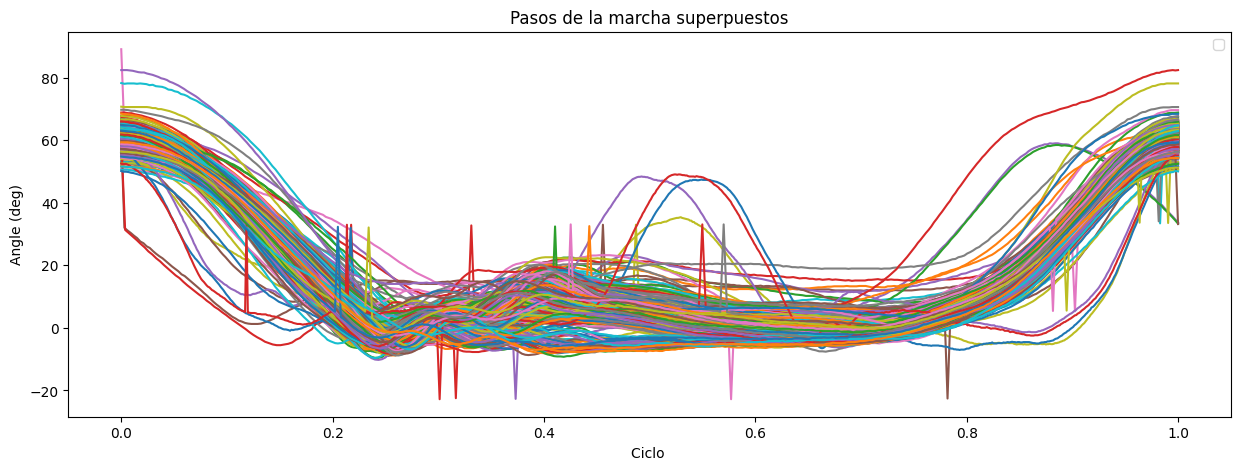

In [58]:
step = [] #almacena segmentos de la señal de angulo

# extrae segmentos de la señal basados en las cumbres
for i in range(1, len(peaks[0])-1):
    step.append(np.array(data_files[0]['Angle'][peaks[0][i]:peaks[0][i+1]]))   

# creacion figura para visualizar
fig = plt.figure(figsize=(15, 5))

#grafico cada segmento de la marcha
for i in range(len(step)):
    t = np.linspace(0, 1, len(step[i]))
    plt.plot(t, step[i])

plt.xlabel('Ciclo ')
plt.ylabel('Angle (deg)')
plt.legend()
plt.title('Pasos de la marcha superpuestos')
plt.show()

### 2.2. Preparando datos

In [59]:
# Definicion muscles
muscles = data_files[0].columns[1:-1]   #columnas del df de musculos en datos de EMG


# Inicializar listas
step = [] #pasos
emg = []  #ventanas de EMG normalizadas
file = [] #indice del archivo de origen de cada paso

# Itero sobre archivos de datos
for index, data in enumerate(data_files):

    # Deteccion de cumbres en la señal de angulo (altura min, distancia min entre cumbres, ancho min de la cumbre)
    peaks = find_peaks(data['Angle'], height=50, distance=125, width=20)

    # Extraccion y Normalizacion de ventanas de datos
    for i in range(1, len(peaks[0])-1):
        step.append(np.array(data['Angle'][peaks[0][i]:peaks[0][i+1]]))
        emg_window = data[muscles][peaks[0][i]:peaks[0][i+1]].reset_index(drop=True)
        emg_window = np.array(emg_window)

        # normalize
        emg_window = (emg_window - emg_window.mean())/emg_window.std() # asegura media 0 y std 1 de los datos
        emg.append(emg_window) # un paso normalizado de la marcha
        file.append(index) # archivo al que pertenece el paso

# Convertir de file a un array de numpy
file = np.array(file)

### 2.3 Visualizar datos EMG por 4 musculos diferentes

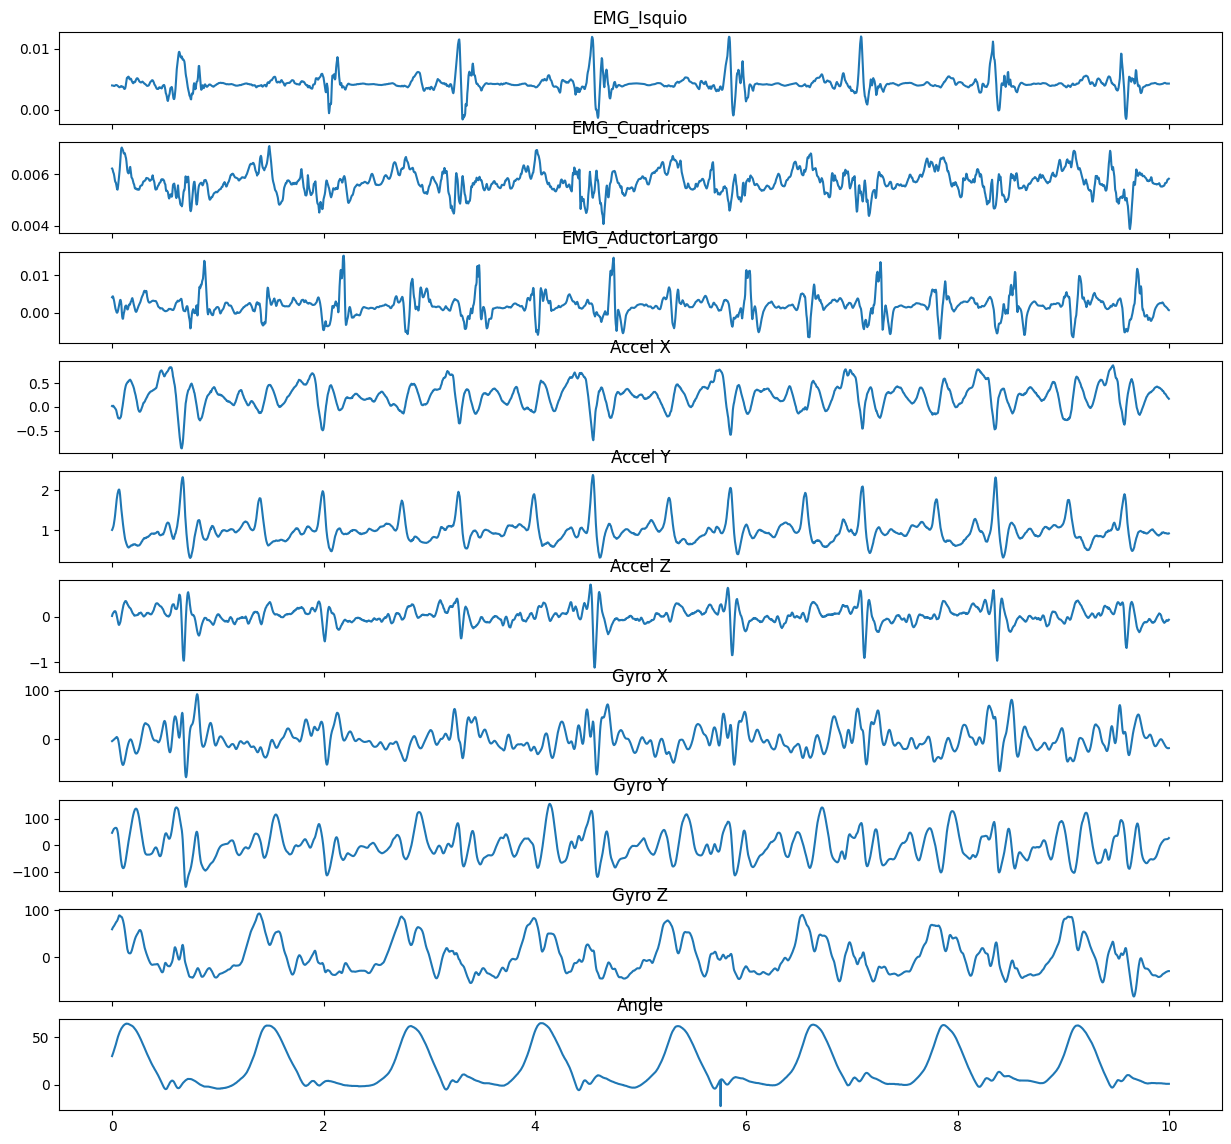

In [60]:
emg_plot(data_files[0])

### 2.4. Define feature extraction function


Caracteristicas Dominio del Tiempo
- **RMS (root mean square):** medida enegia señal - refleja act muscular
- **Varianza:** medidad variabilidad señal - indica cambios en act muscular
- **Kurtosis:** info sobre distribucion datos
- **Skewness:** mide asimetria distribucion señal
- **ZC (zero crossing):** numero de veces que señal cruza el eje cero - indicativo de la frecuencia de disparo de los musculos.

Caracterisicas Dominio de la Frecuencia
- **Espectro de potencia:** distribucion potencia de señal en funcion de frecuencia
- **Mediana de la frecuencia:** frecuencia bajo del cual se encuentra el 50% de la potencia del espectro de la señal
- **Frecuencia Media:** promedio ponderado de las frecuencias presentes en la señal
- **cumbre de Frecuencia:** frecuencia con la mayor potencia en el espectro

Caracteristicas de la Envolvente
- **promedios de la envolvente:** 
- **desviacion estandar de la envolvente:**
- **maximos de la envolvente:**
- **minimos de la envolvente:**

Extraer caracteristicas de datos de EMG

In [61]:
#Funcion extraccion caracteristicas
def extract_feature(data, C=[0], divide=3):
    # data : (T, 4) 
    # T numero de muestras, 4 canales de EMG
    # C numero de indices de canales a usar
    # divide: divide la señal en partes iguales

    result = []
    feature_names = []
    for c in C:
        signal0 = data[:, c]

        # Full wave rectification
        rectified_signal = np.abs(signal0)

        #envolvente
        env = np.abs(signal.hilbert(data[:, c]))

        #RMS
        rms = np.sqrt(np.mean(rectified_signal**2))
        result.append(rms)
        feature_names.append(f"rms_channel_{c}")

        #Varianza
        var = np.var(rectified_signal)
        result.append(var)
        feature_names.append(f"var_channel_{c}")

        #kurtosis
        kurt = scipy.stats.kurtosis(rectified_signal)
        result.append(kurt)
        feature_names.append(f"kurt_channel_{c}")

        #skewness
        skew = scipy.stats.skew(rectified_signal)
        result.append(skew)
        feature_names.append(f"skew_channel_{c}")

        #zero crossing
        zc = ((signal0[:-1] * signal0[1:]) < 0).sum()
        result.append(zc)
        feature_names.append(f"zc_channel_{c}")

        #Frecuencias
        freqs, power_spectrum = scipy.signal.welch(signal0, fs=250, nperseg=32)
        median_freq = freqs[np.where(np.cumsum(power_spectrum) >= np.sum(power_spectrum) / 2)[0][0]]
        mean_freq = np.sum(freqs * power_spectrum) / np.sum(power_spectrum)
        peak_freq = freqs[np.argmax(power_spectrum)]

        result.extend([median_freq, mean_freq, peak_freq])
        feature_names.extend([f"median_freq_channel_{c}", f"mean_freq_channel_{c}", f"peak_freq_channel_{c}"])

        #SEGMENTOS
        for i in range(divide):
            start = int(i*len(data)/divide)
            end = int((i+1)*len(data)/divide)

            segment_env = env[start:end]
            mean_env = segment_env.mean()
            std_env = segment_env.std()
            max_env = segment_env.max()
            min_env = segment_env.min()

            result.extend([mean_env, std_env, max_env, min_env])
            feature_names.extend([f"mean_env_segment_{i}_channel_{c}", f"std_env_segment_{i}_channel_{c}",
                                  f"max_env_segment_{i}_channel_{c}", f"min_env_segment_{i}_channel_{c}"])

    result = np.array(result)
    return result, feature_names

In [62]:
# itera sobre datos (division en fases, extrae caract para cada fase, etiquetado)
# conversion a arrays
def label_data_and_features(data, C= [0, 1, 2], divide=3):
    features = []
    labels = []
    feature_names = None

    for e in data:
        T, _ = e.shape
        for i in range(num_fases):
            start = int(i*T/num_fases)
            end = int((i+1)*T/num_fases)
            extracted_features, names = extract_feature(e[start:end, :], C=C, divide=divide)
            if feature_names is None:
                feature_names = names
            features.append(extracted_features)
            labels.append(i)
    features = np.array(features)
    labels = np.array(labels)
    return features, labels,feature_names

## 3. Training and testing subsets (definir conjuntos de training y testing)

In [63]:
#Preparacion de datos para entrenamiento y prueba
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)


In [64]:
print(f"Train data: Extracted {train_data.shape[0]} samples with {train_data.shape[1]} features each.")
print(f"Train labels shape: {train_labels.shape}")
print("-----------------------------------------------------------------------")
print(f"Test data: Extracted {test_data.shape[0]} samples with {test_data.shape[1]} features each.")
print(f"Test labels shape: {test_labels.shape}")
print("-----------------------------------------------------------------------")

# Imprimir nombres de las características extraídas
print("FEATURES NAMES:")
for name in train_feature_names:
    print(name)

Train data: Extracted 5156 samples with 60 features each.
Train labels shape: (5156,)
-----------------------------------------------------------------------
Test data: Extracted 2620 samples with 60 features each.
Test labels shape: (2620,)
-----------------------------------------------------------------------
FEATURES NAMES:
rms_channel_0
var_channel_0
kurt_channel_0
skew_channel_0
zc_channel_0
median_freq_channel_0
mean_freq_channel_0
peak_freq_channel_0
mean_env_segment_0_channel_0
std_env_segment_0_channel_0
max_env_segment_0_channel_0
min_env_segment_0_channel_0
mean_env_segment_1_channel_0
std_env_segment_1_channel_0
max_env_segment_1_channel_0
min_env_segment_1_channel_0
mean_env_segment_2_channel_0
std_env_segment_2_channel_0
max_env_segment_2_channel_0
min_env_segment_2_channel_0
rms_channel_1
var_channel_1
kurt_channel_1
skew_channel_1
zc_channel_1
median_freq_channel_1
mean_freq_channel_1
peak_freq_channel_1
mean_env_segment_0_channel_1
std_env_segment_0_channel_1
max_env_

## 4. Feature selection/transformation

### Clean y Normalizar

In [65]:
def clean_normalized_feature_selection(train_data, test_data):
  #Se entrena usando Training y Validation
  sclean       = clean(train_data)      # indices of selected features
  train_data = train_data[:,sclean]   # new training
  test_data  = test_data[:,sclean]    # new testing

  train_data, a, b = minmax(train_data)
  test_data        = test_data * a + b

  return train_data, test_data

### SFS

Seleccion de caract con metodo SFS, a prueba y error 45 caracteristicas dio el mejor resultado

In [103]:
def feature_transformation_selection_con_sfs25(train_data, test_data, train_labels):
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  sfs_indices = sfs(train_data, train_labels, 25) # se pide que sean 50 caracterisitcas
  train_data = train_data[:,sfs_indices] # Selecciona las columnas de Xtrain
  test_data  =  test_data[:,sfs_indices] # Selecciona las columnas de Xtest
  print(sfs_indices)
  return train_data, test_data, sfs_indices

In [96]:
def feature_transformation_selection_con_sfs20(train_data, test_data, train_labels):
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  sfs_indices = sfs(train_data, train_labels, 20) # se pide que sean 50 caracterisitcas
  train_data = train_data[:,sfs_indices] # Selecciona las columnas de Xtrain
  test_data  =  test_data[:,sfs_indices] # Selecciona las columnas de Xtest
  print(sfs_indices)
  return train_data, test_data, sfs_indices

In [97]:
def feature_transformation_selection_con_sfs15(train_data, test_data, train_labels):
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  sfs_indices = sfs(train_data, train_labels, 15) # se pide que sean 50 caracterisitcas
  train_data = train_data[:,sfs_indices] # Selecciona las columnas de Xtrain
  test_data  =  test_data[:,sfs_indices] # Selecciona las columnas de Xtest
  print(sfs_indices)
  return train_data, test_data, sfs_indices

In [98]:
def feature_transformation_selection_con_sfs10(train_data, test_data, train_labels):
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  sfs_indices = sfs(train_data, train_labels, 10) # se pide que sean 50 caracterisitcas
  train_data = train_data[:,sfs_indices] # Selecciona las columnas de Xtrain
  test_data  =  test_data[:,sfs_indices] # Selecciona las columnas de Xtest
  print(sfs_indices)
  return train_data, test_data, sfs_indices

In [99]:
def feature_transformation_selection_con_sfs5(train_data, test_data, train_labels):
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  sfs_indices = sfs(train_data, train_labels, 5) # se pide que sean 50 caracterisitcas
  train_data = train_data[:,sfs_indices] # Selecciona las columnas de Xtrain
  test_data  =  test_data[:,sfs_indices] # Selecciona las columnas de Xtest
  print(sfs_indices)
  return train_data, test_data, sfs_indices

### PCA

In [67]:
def feature_transformation_selection_pca10(train_data, test_data):
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  train_data, _, A, Xm, _ = pca(train_data, n_components=10)
  test_data = np.matmul(test_data- Xm, A)

  train_data, a, b = minmax(train_data)
  test_data        = test_data * a + b
  return train_data, test_data

In [68]:
def feature_transformation_selection_pca20(train_data, test_data):
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  train_data, _, A, Xm, _ = pca(train_data, n_components=20)
  test_data = np.matmul(test_data- Xm, A)

  train_data, a, b = minmax(train_data)
  test_data        = test_data * a + b
  return train_data, test_data

In [105]:
def feature_transformation_selection_pca25(train_data, test_data):
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  train_data, _, A, Xm, _ = pca(train_data, n_components=25)
  test_data = np.matmul(test_data- Xm, A)

  train_data, a, b = minmax(train_data)
  test_data        = test_data * a + b
  return train_data, test_data

### ICA

In [107]:
def feature_transformation_selection_ica10(train_data, test_data, train_labels):
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  ica=FastICA(n_components=10, random_state=0)
  ica.fit(train_data, train_labels)
  train_data = ica.transform(train_data)
  test_data = ica.transform(test_data)

  return train_data, test_data

In [91]:
def feature_transformation_selection_ica20(train_data, test_data, train_labels):
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  ica=FastICA(n_components=20, random_state=0)
  ica.fit(train_data, train_labels)
  train_data = ica.transform(train_data)
  test_data = ica.transform(test_data)

  return train_data, test_data

In [108]:
def feature_transformation_selection_ica25(train_data, test_data, train_labels):
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  ica=FastICA(n_components=25, random_state=0)
  ica.fit(train_data, train_labels)
  train_data = ica.transform(train_data)
  test_data = ica.transform(test_data)

  return train_data, test_data

### PLSR

In [76]:
def feature_transformation_selection_plsr10(train_data, test_data, train_labels):
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  plsr = PLSRegression(n_components=10)
  plsr.fit(train_data, train_labels)
  train_data = plsr.transform(train_data)
  test_data = plsr.transform(test_data)

  return train_data, test_data

In [77]:
def feature_transformation_selection_plsr20(train_data, test_data, train_labels):
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  plsr = PLSRegression(n_components=20)
  plsr.fit(train_data, train_labels)
  train_data = plsr.transform(train_data)
  test_data = plsr.transform(test_data)

  return train_data, test_data

In [93]:
def feature_transformation_selection_plsr25(train_data, test_data, train_labels):
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  plsr = PLSRegression(n_components=25)
  plsr.fit(train_data, train_labels)
  train_data = plsr.transform(train_data)
  test_data = plsr.transform(test_data)

  return train_data, test_data

## 5. Classification

In [82]:
def clasificacion(model, train_data, train_labels, test_data):
    model.fit(train_data, train_labels) #Se clasifica el Testing
    y_pred = model.predict(test_data)  #Se calcula el Accuracy en el Testing y se almacena en acc[i]
    return y_pred

### Codigo clasificadores KDE y Mahalonobis

In [83]:
#código de Domingo Mery
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    from https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self

    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [84]:
#código de Domingo Mery
class Mahalanobis(BaseEstimator, ClassifierMixin):

    def __init__(self, covi=1):
        self.covi = covi # 0 covi = Cte, 1 = covi is different

    def fit(self, X, y):
        self.classes  = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes]
        m             = X.shape[1]
        n             = len(self.classes)
        self.mc       = np.zeros((n,m))
        self.Ck       = np.zeros((m,m,n))
        for k in range(n):
            Xk             = training_sets[k]
            self.mc[k]     = np.mean(Xk,axis=0)
            self.Ck[:,:,k] = np.cov(Xk.T)
        if self.covi == 0:
            C       = np.zeros((m,m))
            for k in range(n):
                C  = C + self.Ck[:,:,k]
                C = C/n
            for k in range(n):
                self.Ck[:,:,k] = C
        for k in range(n):
            self.Ck[:,:,k] = np.linalg.inv(self.Ck[:,:,k])
        return self

    def predict_distances(self, Xt):
        n = len(self.classes)
        nt = Xt.shape[0]
        distances = np.zeros((nt,n))
        for k in range(n):
            mk = self.mc[k]
            for i in range(nt):
                xdi  = Xt[i]-mk
                dik   = np.matmul(xdi, self.Ck[:,:,k])
                distances[i,k] = dik.dot(xdi)
        return distances

    def predict(self, X):
        return self.classes[np.argmin(self.predict_distances(X), 1)]

### Lista Clasificadores

In [85]:
classifiers = {
    'knn                               ': KNeighborsClassifier(n_neighbors=1),
    'knn-3                             ': KNeighborsClassifier(n_neighbors=3),
    'knn-5                             ': KNeighborsClassifier(n_neighbors=5),
    'knn-8                             ': KNeighborsClassifier(n_neighbors=8),
    'knn-9                             ': KNeighborsClassifier(n_neighbors=9),
    'knn-10                            ': KNeighborsClassifier(n_neighbors=10),
    'knn-15                            ': KNeighborsClassifier(n_neighbors=15),
    'knn-20                            ': KNeighborsClassifier(n_neighbors=15),
    'mlp                               ': MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    'mlp layers 2                      ': MLPClassifier(hidden_layer_sizes=(100, 50), alpha=1, max_iter=1000, random_state=42),
    'svm lineal 1                      ': SVC(kernel='linear', gamma=0.2, C=0.1),
    'svm lineal 2                      ': SVC(kernel='linear', gamma=0.25, C=0.2),
    'svm polinomial                    ': SVC(kernel='poly', gamma=0.2,degree=3, C=0.1),
    'svm rbf 1                         ': SVC(kernel='rbf', gamma=0.2, C=0.1),
    'svm rbf 2                         ': SVC(kernel='rbf', gamma=0.65, C=0.25),
    'svm rbf 3                         ': SVC(kernel="rbf", random_state=42),
    'svm rbf gamma auto                ': SVC(kernel='rbf', gamma='auto'),
    'svm sigmoidal                     ': SVC(kernel='sigmoid', gamma=0.01, C=1.5),
    'dmin                              ': NearestCentroid(),
    'bayes kde                         ': KDEClassifier(bandwidth=1.0),
    'naive bayes                       ': GaussianNB(),
    'lda                               ': LinearDiscriminantAnalysis(),
    'qda                               ': QuadraticDiscriminantAnalysis(),
    'mahalonobis 0                     ': Mahalanobis(covi=0),
    'mahalonobis original              ': Mahalanobis(),
    'random forest depth 3             ': RandomForestClassifier(max_depth=3,n_estimators=150),
    'random forest depth 15            ': RandomForestClassifier(max_depth=15,n_estimators=150),
    'random forest depth 30            ': RandomForestClassifier(max_depth=30, n_estimators=200),
    'random forest depth 100           ': RandomForestClassifier(max_depth=100,n_estimators=150),
    'random forest n_estimators 300    ': RandomForestClassifier(n_estimators=300),
    'decision tree                     ': DecisionTreeClassifier(max_depth=3),
    'decision tree depth 12            ': DecisionTreeClassifier(max_depth=12),
    'decision tree depth 100           ': DecisionTreeClassifier(max_depth=100),
    'logistic regression lbfgs         ': LogisticRegression(C=0.1,solver="lbfgs"),
    'logistic regression newton-cg     ': LogisticRegression(C=0.2,solver="newton-cg"),
    'gradient boosting                 ': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),
    'adaboost                          ': AdaBoostClassifier(n_estimators=100),
    'extra trees                       ': ExtraTreesClassifier(n_estimators=100),
    'bagging                           ': BaggingClassifier(n_estimators=50),
    'perceptron                        ': Perceptron(max_iter=1000),
    'sgd                               ': SGDClassifier(max_iter=1000, tol=1e-3)
}

## 6. Evaluation

### SOLO Clean y normalizar

In [86]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo1(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
  print(f"Train data: Extracted {train_data.shape[0]} samples with {train_data.shape[1]} features each.")
  print(f"Test data: Extracted {test_data.shape[0]} samples with {test_data.shape[1]} features each.")



  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  
total_accuracies = modelo1(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")

Train data: Extracted 5156 samples with 29 features each.
Test data: Extracted 2620 samples with 29 features each.

Accuracy Total por Clasificador:
knn                               : [0.6706106870229007]
knn-3                             : [0.6824427480916031]
knn-5                             : [0.6732824427480916]
knn-8                             : [0.6583969465648855]
knn-9                             : [0.667175572519084]
knn-10                            : [0.6564885496183206]
knn-15                            : [0.6641221374045801]
knn-20                            : [0.6641221374045801]
mlp                               : [0.7118320610687023]
mlp layers 2                      : [0.732442748091603]
svm lineal 1                      : [0.700381679389313]
svm lineal 2                      : [0.7106870229007634]
svm polinomial                    : [0.47862595419847326]
svm rbf 1                         : [0.6824427480916031]
svm rbf 2                         : [0.716030534351145]

Mejor clean y normalizar:
- svm rbf 3                         : [0.7595419847328244]


### SFS 

In [87]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo2(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data, sfs_indices = feature_transformation_selection_con_sfs25(train_data, test_data, train_labels)

  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  

total_accuracies = modelo2(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")

[28 26  8  5 14 17  9 16 20 18  7 27 24  0  1 19 25  3  6 10 15 12 11 21
  4]

Accuracy Total por Clasificador:
knn                               : [0.6904580152671755]
knn-3                             : [0.6954198473282442]
knn-5                             : [0.6988549618320611]
knn-8                             : [0.6935114503816794]
knn-9                             : [0.6973282442748091]
knn-10                            : [0.6912213740458015]
knn-15                            : [0.6984732824427481]
knn-20                            : [0.6984732824427481]
mlp                               : [0.7389312977099237]
mlp layers 2                      : [0.7541984732824427]
svm lineal 1                      : [0.7068702290076336]
svm lineal 2                      : [0.7171755725190839]
svm polinomial                    : [0.48778625954198473]
svm rbf 1                         : [0.7019083969465649]
svm rbf 2                         : [0.7202290076335878]
svm rbf 3                       

Mejor sfs:
- random forest n_estimators 300    : [0.7778625954198474]


In [100]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo2(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data, sfs_indices = feature_transformation_selection_con_sfs20(train_data, test_data, train_labels)

  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  

total_accuracies = modelo2(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")

[28 26  8  5 14 17  9 16 20 18  7 27 24  0  1 19 25  3  6 10]

Accuracy Total por Clasificador:
knn                               : [0.6950381679389313]
knn-3                             : [0.6977099236641221]
knn-5                             : [0.7019083969465649]
knn-8                             : [0.6938931297709924]
knn-9                             : [0.7118320610687023]
knn-10                            : [0.7019083969465649]
knn-15                            : [0.7072519083969465]
knn-20                            : [0.7072519083969465]
mlp                               : [0.7354961832061069]
mlp layers 2                      : [0.7416030534351145]
svm lineal 1                      : [0.7080152671755725]
svm lineal 2                      : [0.7141221374045802]
svm polinomial                    : [0.3851145038167939]
svm rbf 1                         : [0.7068702290076336]
svm rbf 2                         : [0.7244274809160305]
svm rbf 3                         : [0.7538167938

random forest depth 100           : [0.7824427480916031]


In [101]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo2(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data, sfs_indices = feature_transformation_selection_con_sfs15(train_data, test_data, train_labels)

  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  

total_accuracies = modelo2(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")

[28 26  8  5 14 17  9 16 20 18  7 27 24  0  1]

Accuracy Total por Clasificador:
knn                               : [0.6996183206106871]
knn-3                             : [0.7080152671755725]
knn-5                             : [0.7095419847328245]
knn-8                             : [0.7026717557251908]
knn-9                             : [0.7133587786259542]
knn-10                            : [0.7057251908396946]
knn-15                            : [0.716412213740458]
knn-20                            : [0.716412213740458]
mlp                               : [0.7461832061068703]
mlp layers 2                      : [0.7423664122137404]
svm lineal 1                      : [0.716412213740458]
svm lineal 2                      : [0.7187022900763359]
svm polinomial                    : [0.2687022900763359]
svm rbf 1                         : [0.7156488549618321]
svm rbf 2                         : [0.7267175572519083]
svm rbf 3                         : [0.7519083969465649]
svm rbf ga

random forest n_estimators 300    : [0.7786259541984732]


In [102]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo2(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data, sfs_indices = feature_transformation_selection_con_sfs10(train_data, test_data, train_labels)

  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  

total_accuracies = modelo2(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")

[28 26  8  5 14 17  9 16 20 18]

Accuracy Total por Clasificador:
knn                               : [0.667557251908397]
knn-3                             : [0.6793893129770993]
knn-5                             : [0.6885496183206107]
knn-8                             : [0.6816793893129771]
knn-9                             : [0.6935114503816794]
knn-10                            : [0.6912213740458015]
knn-15                            : [0.6942748091603054]
knn-20                            : [0.6942748091603054]
mlp                               : [0.7080152671755725]
mlp layers 2                      : [0.7061068702290076]
svm lineal 1                      : [0.7053435114503817]
svm lineal 2                      : [0.7011450381679389]
svm polinomial                    : [0.26068702290076334]
svm rbf 1                         : [0.7125954198473282]
svm rbf 2                         : [0.6992366412213741]
svm rbf 3                         : [0.6980916030534351]
svm rbf gamma auto    

mahalonobis 0                     : [0.733587786259542]


In [104]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo2(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data, sfs_indices = feature_transformation_selection_con_sfs5(train_data, test_data, train_labels)

  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  

total_accuracies = modelo2(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")

[28 26  8  5 14]

Accuracy Total por Clasificador:
knn                               : [0.6583969465648855]
knn-3                             : [0.6820610687022901]
knn-5                             : [0.6889312977099237]
knn-8                             : [0.6889312977099237]
knn-9                             : [0.6977099236641221]
knn-10                            : [0.6919847328244275]
knn-15                            : [0.7015267175572519]
knn-20                            : [0.7015267175572519]
mlp                               : [0.7068702290076336]
mlp layers 2                      : [0.7068702290076336]
svm lineal 1                      : [0.6580152671755726]
svm lineal 2                      : [0.6759541984732824]
svm polinomial                    : [0.2595419847328244]
svm rbf 1                         : [0.6137404580152672]
svm rbf 2                         : [0.6896946564885497]
svm rbf 3                         : [0.7022900763358778]
svm rbf gamma auto                : [

qda                               : [0.7202290076335878]


### PCA

In [88]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo3(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data = feature_transformation_selection_pca10(train_data, test_data)

  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  

total_accuracies = modelo3(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")


Accuracy Total por Clasificador:
knn                               : [0.6610687022900763]
knn-3                             : [0.6748091603053435]
knn-5                             : [0.6778625954198473]
knn-8                             : [0.6793893129770993]
knn-9                             : [0.6889312977099237]
knn-10                            : [0.6812977099236641]
knn-15                            : [0.6824427480916031]
knn-20                            : [0.6824427480916031]
mlp                               : [0.7156488549618321]
mlp layers 2                      : [0.6984732824427481]
svm lineal 1                      : [0.6938931297709924]
svm lineal 2                      : [0.6996183206106871]
svm polinomial                    : [0.5698473282442749]
svm rbf 1                         : [0.6576335877862596]
svm rbf 2                         : [0.7022900763358778]
svm rbf 3                         : [0.7194656488549618]
svm rbf gamma auto                : [0.700381679389313

Mejor hasta ahora en PCA 10 comp:
- mahalonobis 0                     : [0.732824427480916]

In [89]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo32(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data = feature_transformation_selection_pca20(train_data, test_data)

  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  

total_accuracies = modelo32(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")


Accuracy Total por Clasificador:
knn                               : [0.650381679389313]
knn-3                             : [0.6591603053435114]
knn-5                             : [0.6564885496183206]
knn-8                             : [0.6576335877862596]
knn-9                             : [0.6637404580152672]
knn-10                            : [0.6545801526717557]
knn-15                            : [0.6522900763358779]
knn-20                            : [0.6522900763358779]
mlp                               : [0.7393129770992366]
mlp layers 2                      : [0.7473282442748092]
svm lineal 1                      : [0.7229007633587786]
svm lineal 2                      : [0.7377862595419847]
svm polinomial                    : [0.716793893129771]
svm rbf 1                         : [0.6980916030534351]
svm rbf 2                         : [0.748854961832061]
svm rbf 3                         : [0.766412213740458]
svm rbf gamma auto                : [0.7209923664122138]
s

Mejor hasta ahora en PCA 20 comp:
- svm rbf 3                         : [0.766412213740458]


In [106]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo32(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data = feature_transformation_selection_pca25(train_data, test_data)

  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  

total_accuracies = modelo32(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")


Accuracy Total por Clasificador:
knn                               : [0.6179389312977099]
knn-3                             : [0.6274809160305344]
knn-5                             : [0.6312977099236641]
knn-8                             : [0.6206106870229008]
knn-9                             : [0.6270992366412214]
knn-10                            : [0.6248091603053435]
knn-15                            : [0.6339694656488549]
knn-20                            : [0.6339694656488549]
mlp                               : [0.7412213740458016]
mlp layers 2                      : [0.7255725190839695]
svm lineal 1                      : [0.7183206106870229]
svm lineal 2                      : [0.7274809160305343]
svm polinomial                    : [0.716793893129771]
svm rbf 1                         : [0.6809160305343511]
svm rbf 2                         : [0.7232824427480916]
svm rbf 3                         : [0.7645038167938931]
svm rbf gamma auto                : [0.7152671755725191

svm rbf 3                         : [0.7645038167938931]


### ICA

In [92]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo4(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data = feature_transformation_selection_ica20(train_data, test_data, train_labels)

  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  

total_accuracies = modelo4(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")


Accuracy Total por Clasificador:
knn                               : [0.6164122137404581]
knn-3                             : [0.6320610687022901]
knn-5                             : [0.6293893129770992]
knn-8                             : [0.6316793893129771]
knn-9                             : [0.6351145038167939]
knn-10                            : [0.6377862595419848]
knn-15                            : [0.6393129770992366]
knn-20                            : [0.6393129770992366]
mlp                               : [0.7893129770992366]
mlp layers 2                      : [0.7923664122137405]
svm lineal 1                      : [0.7599236641221374]
svm lineal 2                      : [0.7580152671755725]
svm polinomial                    : [0.7354961832061069]
svm rbf 1                         : [0.467175572519084]
svm rbf 2                         : [0.29236641221374043]
svm rbf 3                         : [0.7534351145038168]
svm rbf gamma auto                : [0.753435114503816

- mlp layers 2                      : [0.7923664122137405]


In [109]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo4(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data = feature_transformation_selection_ica10(train_data, test_data, train_labels)

  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  

total_accuracies = modelo4(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")


Accuracy Total por Clasificador:
knn                               : [0.6614503816793893]
knn-3                             : [0.6683206106870229]
knn-5                             : [0.6805343511450381]
knn-8                             : [0.665648854961832]
knn-9                             : [0.6759541984732824]
knn-10                            : [0.6645038167938931]
knn-15                            : [0.6763358778625954]
knn-20                            : [0.6763358778625954]
mlp                               : [0.7274809160305343]
mlp layers 2                      : [0.7381679389312977]
svm lineal 1                      : [0.6969465648854962]
svm lineal 2                      : [0.6946564885496184]
svm polinomial                    : [0.6874045801526718]
svm rbf 1                         : [0.6786259541984733]
svm rbf 2                         : [0.6320610687022901]
svm rbf 3                         : [0.7141221374045802]
svm rbf gamma auto                : [0.7141221374045802

random forest depth 100           : [0.7484732824427481]


In [110]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo4(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data = feature_transformation_selection_ica25(train_data, test_data, train_labels)

  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  

total_accuracies = modelo4(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")


Accuracy Total por Clasificador:
knn                               : [0.5709923664122137]
knn-3                             : [0.5816793893129771]
knn-5                             : [0.5782442748091603]
knn-8                             : [0.5847328244274809]
knn-9                             : [0.5816793893129771]
knn-10                            : [0.5820610687022901]
knn-15                            : [0.5927480916030534]
knn-20                            : [0.5927480916030534]
mlp                               : [0.7801526717557252]
mlp layers 2                      : [0.7732824427480917]
svm lineal 1                      : [0.7477099236641221]
svm lineal 2                      : [0.7461832061068703]
svm polinomial                    : [0.7118320610687023]
svm rbf 1                         : [0.3748091603053435]
svm rbf 2                         : [0.26259541984732826]
svm rbf 3                         : [0.73206106870229]
svm rbf gamma auto                : [0.73206106870229]


mlp                               : [0.7801526717557252]


### PLSR

In [ ]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo5(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data = feature_transformation_selection_plsr10(train_data, test_data, train_labels)

  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  

total_accuracies = modelo5(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")


Accuracy Total por Clasificador:
knn                               : [0.65]
knn-3                             : [0.75]
knn-5                             : [0.7833333333333333]
knn-8                             : [0.8333333333333334]
knn-9                             : [0.8]
knn-10                            : [0.85]
knn-15                            : [0.85]
knn-20                            : [0.85]
mlp                               : [0.8333333333333334]
mlp layers 2                      : [0.8333333333333334]
svm lineal 1                      : [0.7666666666666667]
svm lineal 2                      : [0.7666666666666667]
svm polinomial                    : [0.7833333333333333]
svm rbf 1                         : [0.75]
svm rbf 2                         : [0.4666666666666667]
svm rbf 3                         : [0.8333333333333334]
svm rbf gamma auto                : [0.8333333333333334]
svm sigmoidal                     : [0.8]
dmin                              : [0.75]
bayes kde  

naive bayes                       : [0.85]


In [ ]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo5(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data = feature_transformation_selection_plsr20(train_data, test_data, train_labels)

  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  

total_accuracies = modelo5(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")


Accuracy Total por Clasificador:
knn                               : [0.8166666666666667]
knn-3                             : [0.8]
knn-5                             : [0.8166666666666667]
knn-8                             : [0.8666666666666667]
knn-9                             : [0.8666666666666667]
knn-10                            : [0.8833333333333333]
knn-15                            : [0.85]
knn-20                            : [0.85]
mlp                               : [0.8833333333333333]
mlp layers 2                      : [0.8333333333333334]
svm lineal 1                      : [0.8166666666666667]
svm lineal 2                      : [0.8]
svm polinomial                    : [0.8166666666666667]
svm rbf 1                         : [0.5333333333333333]
svm rbf 2                         : [0.38333333333333336]
svm rbf 3                         : [0.8666666666666667]
svm rbf gamma auto                : [0.8666666666666667]
svm sigmoidal                     : [0.816666666666666

A continuación, con los mejores resultados haré combinaciones de estos selecionadores y/o transformadores. 

- mlp                               : [0.8833333333333333]
- knn-10                            : [0.8833333333333333]


In [94]:
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)

def modelo5(train_data, test_data,train_labels,test_labels, classifiers):
  accuracies = {name: [] for name in classifiers.keys()}
  train_data, test_data = feature_transformation_selection_plsr25(train_data, test_data, train_labels)

  for name, clf in classifiers.items():
    ypred = clasificacion(clf, train_data, train_labels, test_data)
    accuracy = accuracy_score(test_labels, ypred)
    accuracies[name].append(accuracy)
  return accuracies
  

total_accuracies = modelo5(train_data, test_data,train_labels,test_labels, classifiers)
print("\nAccuracy Total por Clasificador:")
for name, acc in total_accuracies.items():
    print(f"{name}: {acc}")


Accuracy Total por Clasificador:
knn                               : [0.6351145038167939]
knn-3                             : [0.6534351145038167]
knn-5                             : [0.6435114503816793]
knn-8                             : [0.6366412213740458]
knn-9                             : [0.649618320610687]
knn-10                            : [0.6416030534351145]
knn-15                            : [0.6442748091603053]
knn-20                            : [0.6442748091603053]
mlp                               : [0.768320610687023]
mlp layers 2                      : [0.7687022900763358]
svm lineal 1                      : [0.732442748091603]
svm lineal 2                      : [0.7343511450381679]
svm polinomial                    : [0.7354961832061069]
svm rbf 1                         : [0.5125954198473283]
svm rbf 2                         : [0.30267175572519084]
svm rbf 3                         : [0.7435114503816794]
svm rbf gamma auto                : [0.7427480916030534]

### SFS & PCA

### SFS & ICA

### SFS & PLSR

### PCA & ICA

### PCA & PLSR

### ICA & PLSR

### PCA & ICA & PLSR

### SFS & PCA & ICA & PLSR

### SFS & PCA & ICA 

### SFS & PCA & PLSR

### SFS & ICA & PLSR